In [1]:
import sys
sys.path.append('/home/jovyan/workspace')

In [2]:
# %%sh
# rm -rf '../data/test'

In [3]:
import planetengine
from planetengine import functions as pfn
import numpy as np
from timeit import timeit

In [4]:
system = planetengine.systems.arrhenius.build(res = 64)
initials = {'temperatureField': planetengine.initials.sinusoidal.IC(freq = 1.)}
planetengine.initials.apply(
    initials,
    system,
    )
system.solve()

In [5]:
variable1 = pfn.convert(system.velocityField, 'velocity')
variable2 = pfn.convert(system.temperatureField, 'temperature')
constant = pfn.convert(2.)
shape = pfn.convert(np.array([[0.2, 0.1], [0.9, 0.3], [0.8, 0.7], [0.4, 0.9]]))
vanilla = pfn.convert(system.viscosityFn, 'viscosity')

In [6]:
# var = variable1
# var = pfn.Region(var, shape)
# var = pfn.Component.rad(var)
# var = pfn.Gradient.mag(var)
# var = pfn.Normalise(var, [0., 1.])
# var = pfn.Quantiles.median(var)
# var = pfn.Filter(var, 1.)
# var = pfn.Gradient.rad(var)
# var = pfn.Binarise(var)
# var = var * vanilla
# var = var ** constant
# var = var * variable2
# var = pfn.Projection(var)
# var = pfn.HandleNaN.zero(var)
# planetengine.quickShow(var.mesh, var)

In [7]:
def makevar():
    var = variable1
    var = pfn.Region(var, shape)
    var = pfn.Component.rad(var)
    var = pfn.Gradient.mag(var)
    var = pfn.Quantiles.median(var)
    var = pfn.Filter(var, 1.)
    var = pfn.Gradient.rad(var)
    var = pfn.Normalise(var, [0., 1.])
    var = pfn.Binarise(var)
    var = var * vanilla
    var = var ** constant
    var = var * variable2
    var = pfn.HandleNaN.zero(var)
    var = pfn.Normalise(var, [0., 1.])
    return var

In [8]:
print(round(timeit(makevar, number = 3) / 3, 3))

3.06


In [9]:
var = makevar()

Fitted 1 variables to the figure.
Normalise{HandleNaN{Operation_uwop=multiply{Operation_uwop=pow{Operation_uwop=multiply{Binarise{Normalise{Component_component=rad{Gradient{Filter{Quantiles_ntiles=2{Component_component=mag{Gradient{Component_component=rad{Region{Variable_varName=velocity{};Shape_varName=anon{}}}}}};Constant_val=arr{[ 1.]}{}}}};Constant_val=arr{[ 0.  1.]}{}}};Vanilla_varName=viscosity{Variable_varName=temperature{}}};Constant_val=arr{[ 2.]}{}};Variable_varName=temperature{}};Constant_val=arr{[ 0.]}{}};Constant_val=arr{[ 0.  1.]}{}}



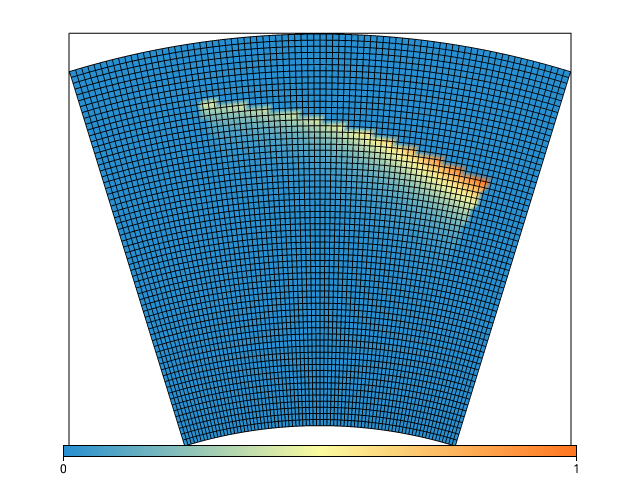

In [10]:
planetengine.quickShow(var.mesh, var)

In [11]:
def testfn(var, timings = '', layer = 1):
    def outer_timefn(var, timinglist = []):
        planetengine.initials.apply(
            initials,
            system,
            )
        var.update()
        system.iterate()
        timing = timeit(var.update, number = 1)
        timinglist.append(timing)
        return timinglist
    var_timings = []
    for i in range(10):
        var_timings = outer_timefn(var, var_timings)
    var_timing = sum(var_timings) / len(var_timings)
    var_timing = round(var_timing, 6)
    timings += '\n'
    newrow = ''
    newrow += layer * '-' + ' '
    newrow += var.opTag
    newrow += ': '
    newrow += '.' * (56 - len(newrow)) + ' '
    newrow += str(var_timing)
    timings += newrow
    for inVar in var.inVars:
        timings = testfn(inVar, timings, layer + 1)
    return timings

In [12]:
timings = testfn(var)

In [13]:
print(timings)


- Normalise: ........................................... 0.455004
-- HandleNaN: .......................................... 0.127712
--- Operation_uwop=multiply: ........................... 0.070159
---- Operation_uwop=pow: ............................... 0.03844
----- Operation_uwop=multiply: ......................... 0.019391
------ Binarise: ....................................... 0.00055
------- Normalise: ..................................... 0.000539
-------- Component_component=rad: ...................... 0.000795
--------- Gradient: .................................... 0.000702
---------- Filter: ..................................... 0.000646
----------- Quantiles_ntiles=2: ........................ 0.000538
------------ Component_component=mag: .................. 0.000508
------------- Gradient: ................................ 0.000479
-------------- Component_component=rad: ................ 0.000504
--------------- Region: ................................ 0.000462
-----------

In [14]:
red = pfn.Integral(var)

In [15]:
planetengine.initials.apply(
    initials,
    system,
    )
red.update()
system.iterate()
print(red.evaluate())
print(red.evaluate())
system.iterate()
print(red.evaluate())
print(red.evaluate())

[[ 0.03162124]]
[[ 0.03162124]]
[[ 0.03161639]]
[[ 0.03161639]]


In [16]:
def testfn():
    freshsteps = []
    stalesteps = []
    for i in range(3):
        planetengine.initials.apply(
            initials,
            system,
            )
        red.update
        system.iterate()
        freshsteps.append(timeit(red.update, number = 1))
    for i in range(3):
        stalesteps.append(timeit(red.update, number = 1))
    average_fresh = round(sum(freshsteps) / len(freshsteps), 5)
    average_stale = round(sum(stalesteps) / len(stalesteps), 5)
    ratio = round(average_fresh / average_stale, 5)
    return(average_fresh, average_stale, ratio)
print(testfn())

(0.74486, 0.0005, 1489.72)
